In [165]:
#Import Library
import os
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from keras.preprocessing import image
from mpl_toolkits.axes_grid1 import ImageGrid
from sklearn.metrics import  classification_report
from sklearn.model_selection import train_test_split
from keras.models import Model, Sequential
from keras.layers import Activation, Dense, Dropout, Input, Masking
from keras.preprocessing.image import load_img

In [166]:
#Load DataSet
data_folder = r"C:\Users\abdel\PycharmProjects\Fire Detection\Dataset"
train_data_folder = r"C:\Users\abdel\PycharmProjects\Fire Detection\Dataset/fire_images"
test_date_folder  = r"C:\Users\abdel\PycharmProjects\Fire Detection\Dataset/non_fire_images"

categories = ['fire_images', 'non_fire_images']
len_categories = len(categories)
len_categories

2

In [167]:
image_count = {}
train_data = []

# loop to count the number of fire image and non-fire
for i, category in enumerate(categories):
    class_folder = os.path.join(data_folder, category)
    label = category
    image_count[category] = []
    for path in os.listdir(class_folder):
        image_count[category].append(category)
        train_data.append(['{}/{}'.format(category, path), i, category])
# Show image count
for key, value in image_count.items():
    print('{0} -> {1}'.format(key, len(value)))


fire_images -> 755
non_fire_images -> 244


In [168]:
#create a dataframe
df = pd.DataFrame(train_data, columns=['file', 'id', 'label'])
df.shape
print("The First 5 Rows in Train_data")
df.head()
print("The Last 5 Rows in Train_data")
df.tail()

(999, 3)

The First 5 Rows in Train_data


,file,id,label
0,fire_images/fire.1.png,0,fire_images
1,fire_images/fire.10.png,0,fire_images
2,fire_images/fire.100.png,0,fire_images
3,fire_images/fire.101.png,0,fire_images
4,fire_images/fire.102.png,0,fire_images


The Last 5 Rows in Train_data


,file,id,label
994,non_fire_images/non_fire.95.png,1,non_fire_images
995,non_fire_images/non_fire.96.png,1,non_fire_images
996,non_fire_images/non_fire.97.png,1,non_fire_images
997,non_fire_images/non_fire.98.png,1,non_fire_images
998,non_fire_images/non_fire.99.png,1,non_fire_images


In [139]:
#IMAGE PREPROCESSING
#masking function
def create_mask_for_plant(image):
    image_hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    #The Threshold
    lower_hsv = np.array([0,0,250])
    upper_hsv = np.array([250,255,255])
    # inRange => used to create a binary mask by thresholding the input image
    mask = cv2.inRange(image_hsv, lower_hsv, upper_hsv)
    #getStructuringElement => creating a structuring element, which is a kernel used for morphological operations.
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (11,11))
    #morphologyEx => applies a morphological operation
    mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel)
    return mask

#image segmentation function
def segment_image(image):
    mask = create_mask_for_plant(image)
    #bitwise_and => performs a bitwise AND operation between the original image
    output = cv2.bitwise_and(image, image, mask = mask)
    return output/255

#sharpen the image
def sharpen_image(image):
    image_blurred = cv2.GaussianBlur(image, (0, 0), 3)
    image_sharp = cv2.faddWeighted(image, 1.5, image_blurred, -0.5, 0)
    return image_sharp

# function to get an image
def read_img(filepath, size):
    img = image.load_img(os.path.join(data_folder, filepath), target_size=size)
    #convert image to array
    img = image.img_to_array(img)
    return img

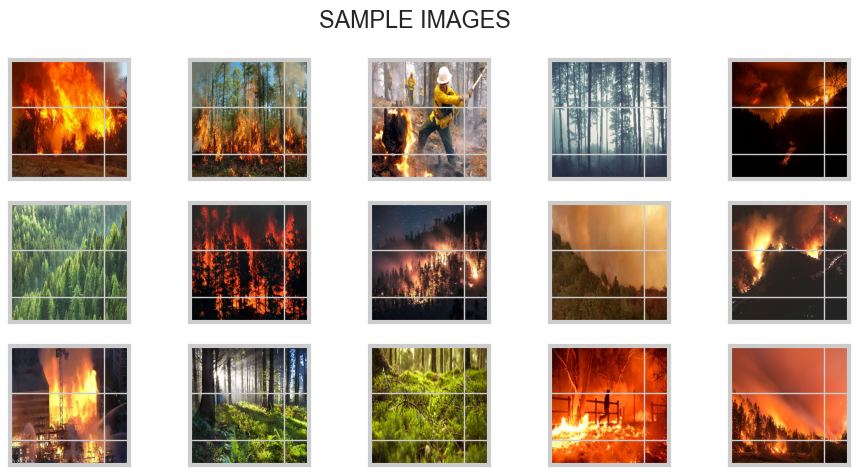

In [140]:
#SHOW SAMPLE IMAGES
nb_rows = 3
nb_cols = 5
fig, axs = plt.subplots(nb_rows, nb_cols, figsize=(10, 5));
plt.suptitle('SAMPLE IMAGES');
for i in range(0, nb_rows):
    for j in range(0, nb_cols):
        axs[i, j].xaxis.set_ticklabels([]);
        axs[i, j].yaxis.set_ticklabels([]);
        axs[i, j].imshow((read_img(df['file'][np.random.randint(1000)], (255,255)))/255.);
plt.show();

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


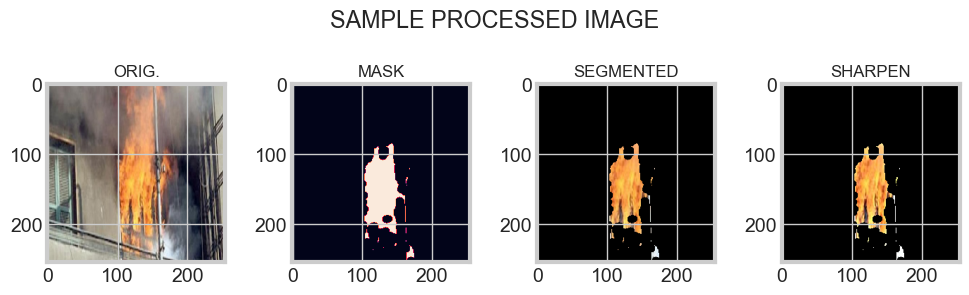

In [192]:
#SHOW SAMPLE PROCESSED IMAGE
#get an image
img = read_img(df['file'][108],(255,255))
#mask
image_mask = create_mask_for_plant(img)
#segmentation
image_segmented = segment_image(img)
#sharpen the image
image_sharpen = sharpen_image(image_segmented)

fig, ax = plt.subplots(1, 4, figsize=(10, 5));
plt.suptitle('SAMPLE PROCESSED IMAGE', x=0.5, y=0.8)
plt.tight_layout()
ax[0].set_title('ORIG.', fontsize=12)
ax[1].set_title('MASK', fontsize=12)
ax[2].set_title('SEGMENTED', fontsize=12)
ax[3].set_title('SHARPEN', fontsize=12)
ax[0].imshow(img/255);
ax[1].imshow(image_mask);
ax[2].imshow(image_segmented);
ax[3].imshow(image_sharpen);

In [144]:
# Histogram-based feature extraction
def extract_histogram_features(image):
    hsv_image = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    hist_hue = cv2.calcHist([hsv_image], [0], None, [256], [0, 256])
    hist_saturation = cv2.calcHist([hsv_image], [1], None, [256], [0, 256])
    hist_value = cv2.calcHist([hsv_image], [2], None, [256], [0, 256])
    hist_hue = hist_hue.flatten()
    hist_saturation = hist_saturation.flatten()
    hist_value = hist_value.flatten()
    features = np.concatenate((hist_hue, hist_saturation, hist_value))
    return features

In [145]:
# SPLIT THE DATA for histogram features
X = np.array([read_img(filepath, (224, 224)) for filepath in df['file']])
X_features = np.array([extract_histogram_features(image) for image in X])
X_train1, X_val1, y_train1, y_val1 = train_test_split(X_features, df['id'], test_size=0.2, random_state=101)

In [185]:
# GLCM feature extraction
def extract_glcm_features(image):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    gray_uint8 = cv2.convertScaleAbs(gray)
    _, binary_image = cv2.threshold(gray_uint8, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    glcm = np.zeros((256, 256), dtype=np.float64)

    for i in range(1, binary_image.shape[0]):
        for j in range(1, binary_image.shape[1]):
            glcm[binary_image[i, j-1], binary_image[i, j]] += 1

    glcm /= np.sum(glcm)
    properties = ['contrast', 'dissimilarity', 'homogeneity', 'energy', 'correlation']
    features = []

    for prop in properties:
        prop_value = np.sum(glcm * (np.arange(256, dtype=np.float64)[:, np.newaxis] - np.arange(256, dtype=np.float64))**2)
        features.append(prop_value)
    return features

In [186]:
# SPLIT THE DATA for GLCM features
X = np.array([read_img(filepath, (224, 224)) for filepath in df['file']])
X_features = np.array([extract_glcm_features(image) for image in X])
X_train2, X_val2, y_train2, y_val2 = train_test_split(X_features, df['id'], test_size=0.2, random_state=101)

In [148]:
# DEEP LEARNING MODEL with Dropout for histogram features
model1 = Sequential()
model1.add(Dense(units=256, activation='relu', input_dim=X_train1.shape[1]))
model1.add(Dropout(0.5))  # Add Dropout layer with a dropout rate of 0.5 (adjust as needed)
model1.add(Dense(units=64, activation='relu'))
model1.add(Dropout(0.5))  # Add Dropout layer with a dropout rate of 0.5 (adjust as needed)
model1.add(Dense(units=1, activation='sigmoid'))
model1.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model1.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_15 (Dense)            (None, 256)               196864    
                                                                 
 dropout_2 (Dropout)         (None, 256)               0         
                                                                 
 dense_16 (Dense)            (None, 64)                16448     
                                                                 
 dropout_3 (Dropout)         (None, 64)                0         
                                                                 
 dense_17 (Dense)            (None, 1)                 65        
                                                                 
Total params: 213377 (833.50 KB)
Trainable params: 213377 (833.50 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [149]:
# DEEP LEARNING MODEL with Dropout for GLCM features
model2 = Sequential()
model2.add(Dense(units=256, activation='relu', input_dim=X_train2.shape[1]))
model2.add(Dropout(0.5))  # Add Dropout layer with a dropout rate of 0.5 (adjust as needed)
model2.add(Dense(units=64, activation='relu'))
model2.add(Dropout(0.5))  # Add Dropout layer with a dropout rate of 0.5 (adjust as needed)
model2.add(Dense(units=1, activation='sigmoid'))
model2.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model2.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_18 (Dense)            (None, 256)               1536      
                                                                 
 dropout_4 (Dropout)         (None, 256)               0         
                                                                 
 dense_19 (Dense)            (None, 64)                16448     
                                                                 
 dropout_5 (Dropout)         (None, 64)                0         
                                                                 
 dense_20 (Dense)            (None, 1)                 65        
                                                                 
Total params: 18049 (70.50 KB)
Trainable params: 18049 (70.50 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [153]:
# Train the models
history1 = model1.fit(X_train1, y_train1, epochs=10, batch_size=32)
history2 = model2.fit(X_train2, y_train2, epochs=10, batch_size=32)

Epoch 1/10
25/25 [==============================] - 0s 5ms/step - loss: 9.9409 - accuracy: 0.8723
Epoch 2/10
25/25 [==============================] - 0s 4ms/step - loss: 9.9886 - accuracy: 0.8723
Epoch 3/10
25/25 [==============================] - 0s 5ms/step - loss: 7.1455 - accuracy: 0.8636
Epoch 4/10
25/25 [==============================] - 0s 5ms/step - loss: 6.0950 - accuracy: 0.8461
Epoch 5/10
25/25 [==============================] - 0s 4ms/step - loss: 4.8664 - accuracy: 0.8761
Epoch 6/10
25/25 [==============================] - 0s 5ms/step - loss: 4.6629 - accuracy: 0.8523
Epoch 7/10
25/25 [==============================] - 0s 5ms/step - loss: 2.6286 - accuracy: 0.8360
Epoch 8/10
25/25 [==============================] - 0s 4ms/step - loss: 4.0181 - accuracy: 0.8573
Epoch 9/10
25/25 [==============================] - 0s 5ms/step - loss: 2.6081 - accuracy: 0.8623
Epoch 10/10
25/25 [==============================] - 0s 4ms/step - loss: 2.6219 - accuracy: 0.8548
Epoch 1/10
25/25 [=

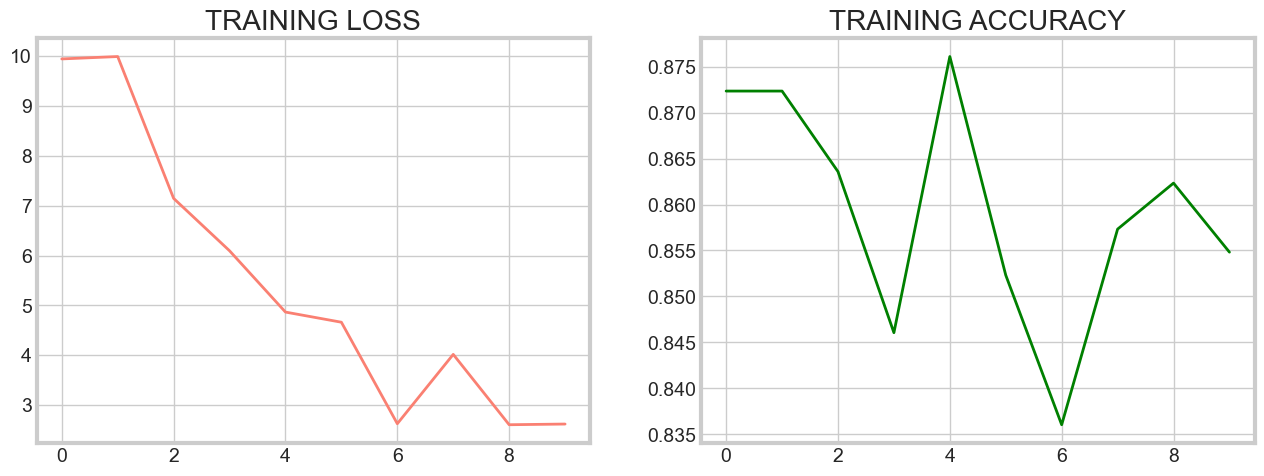

In [164]:
# LOSS AND ACCURACY for model2
fig, ax = plt.subplots(1, 2, figsize=(14, 5))
ax[0].set_title('TRAINING LOSS')
ax[1].set_title('TRAINING ACCURACY')
ax[0].plot(history1.history['loss'], color='salmon', lw=2)
ax[1].plot(history1.history['accuracy'], color='green', lw=2)
plt.show();

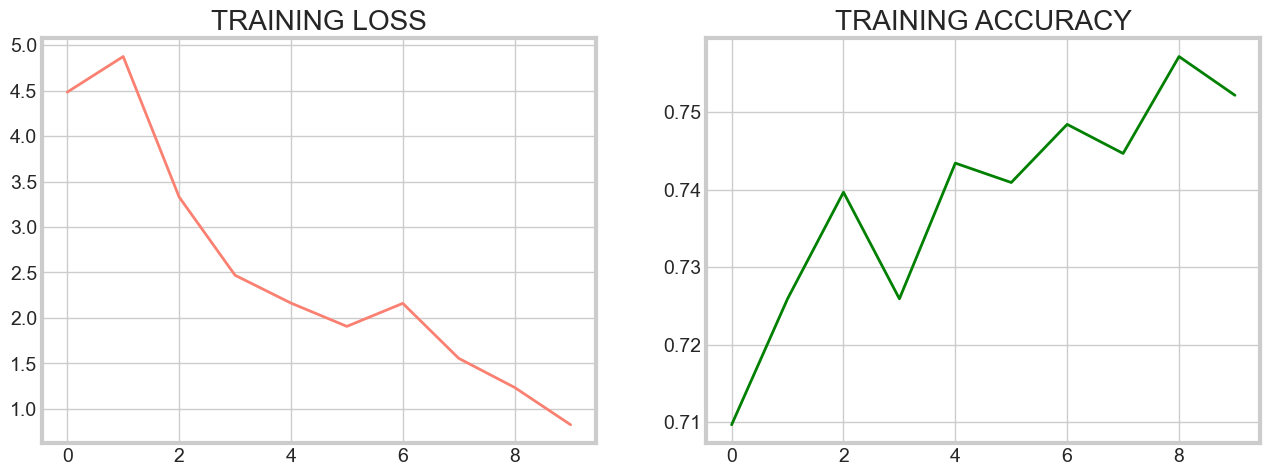

In [163]:
# LOSS AND ACCURACY for model2
fig, ax = plt.subplots(1, 2, figsize=(14, 5))
ax[0].set_title('TRAINING LOSS')
ax[1].set_title('TRAINING ACCURACY')
ax[0].plot(history2.history['loss'], color='salmon', lw=2)
ax[1].plot(history2.history['accuracy'], color='green', lw=2)
plt.show();

In [134]:
# Print classification reports
print("Classification Report for Histogram Features:")
print(classification_report(y_val1, predicted_classes1))


7/7 [==============================] - 0s 2ms/step


In [157]:
# Evaluate the models on validation data
predictions1 = model1.predict(X_val1)
predictions2 = model2.predict(X_val2)
predicted_classes1 = (predictions1 > 0.5).astype(int)
predicted_classes2 = (predictions2 > 0.5).astype(int)

7/7 [==============================] - 0s 2ms/step


In [158]:
# Print classification reports
print("Classification Report for Histogram Features:")
print(classification_report(y_val1, predicted_classes1))

Classification Report for Histogram Features:
              precision    recall  f1-score   support

           0       0.83      1.00      0.91       145
           1       1.00      0.47      0.64        55

    accuracy                           0.85       200
   macro avg       0.92      0.74      0.78       200
weighted avg       0.88      0.85      0.84       200



In [159]:
print("Classification Report for GLCM Features:")
print(classification_report(y_val2, predicted_classes2))

Classification Report for GLCM Features:
              precision    recall  f1-score   support

           0       0.72      1.00      0.84       145
           1       0.00      0.00      0.00        55

    accuracy                           0.73       200
   macro avg       0.36      0.50      0.42       200
weighted avg       0.53      0.72      0.61       200



C:\Users\abdel\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\abdel\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\abdel\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


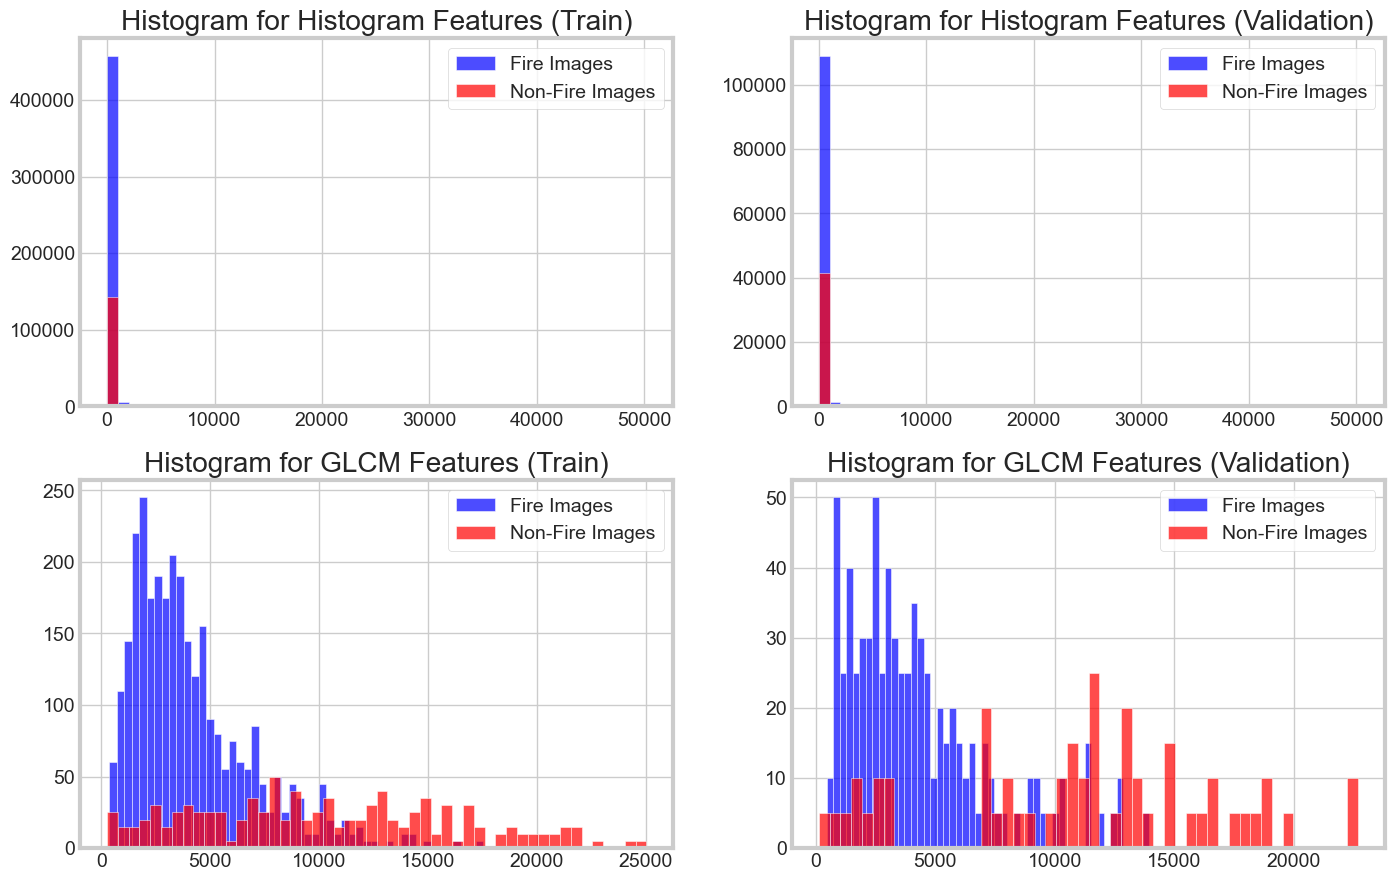

In [162]:
# Plot histograms for both feature extraction methods
fig, axs = plt.subplots(2, 2, figsize=(15, 10))

axs[0, 0].hist(X_train1[y_train1 == 0].flatten(), bins=50, color='blue', alpha=0.7, label='Fire Images')
axs[0, 0].hist(X_train1[y_train1 == 1].flatten(), bins=50, color='red', alpha=0.7, label='Non-Fire Images')
axs[0, 0].set_title('Histogram for Histogram Features (Train)')
axs[0, 0].legend()

axs[0, 1].hist(X_val1[y_val1 == 0].flatten(), bins=50, color='blue', alpha=0.7, label='Fire Images')
axs[0, 1].hist(X_val1[y_val1 == 1].flatten(), bins=50, color='red', alpha=0.7, label='Non-Fire Images')
axs[0, 1].set_title('Histogram for Histogram Features (Validation)')
axs[0, 1].legend()

axs[1, 0].hist(X_train2[y_train2 == 0].flatten(), bins=50, color='blue', alpha=0.7, label='Fire Images')
axs[1, 0].hist(X_train2[y_train2 == 1].flatten(), bins=50, color='red', alpha=0.7, label='Non-Fire Images')
axs[1, 0].set_title('Histogram for GLCM Features (Train)')
axs[1, 0].legend()

axs[1, 1].hist(X_val2[y_val2 == 0].flatten(), bins=50, color='blue', alpha=0.7, label='Fire Images')
axs[1, 1].hist(X_val2[y_val2 == 1].flatten(), bins=50, color='red', alpha=0.7, label='Non-Fire Images')
axs[1, 1].set_title('Histogram for GLCM Features (Validation)')
axs[1, 1].legend()
plt.show();


In [187]:
# Print accuracy
accuracy1 = accuracy_score(y_val1, predicted_classes1)
accuracy2 = accuracy_score(y_val2, predicted_classes2)

print("Accuracy for Histogram Features:", accuracy1)
print("Accuracy for GLCM Features:", accuracy2)

Accuracy for Histogram Features: 0.855
Accuracy for GLCM Features: 0.725


Text(0.5, 1.0, 'DETECTED IMAGE')

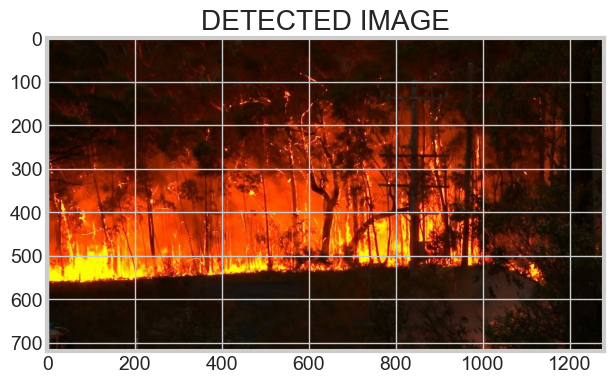

1/1 [==============================] - 0s 32ms/step
Prediction using Histogram Features: fire_images
Prediction using GLCM Features: fire_images


In [226]:
# Load and preprocess the test image
test_image_path = r"C:\Users\abdel\PycharmProjects\Fire Detection\Dataset\fire_images\fire.3.png"
#test_image_path = r"C:\Users\abdel\PycharmProjects\Fire Detection\Dataset\non_fire_images\non_fire.1.png"
#test_image_path = r"C:\Users\abdel\PycharmProjects\Fire Detection\Dataset\non_fire_images\non_fire.110.png"

# Display the test photo with the predicted class
plt.imshow(cv2.cvtColor(cv2.imread(test_image_path), cv2.COLOR_BGR2RGB))
plt.title("DETECTED IMAGE")
plt.show()

test_image = read_img(test_image_path, (224, 224))
# Extract features from the test image
histogram_features = extract_histogram_features(test_image)
glcm_features = extract_glcm_features(test_image)

# Convert features to numpy arrays
histogram_features = np.array(histogram_features)
glcm_features = np.array(glcm_features)

# Reshape features to match the input dimensions of the models
histogram_features = histogram_features.reshape(1, -1)
glcm_features = glcm_features.reshape(1, -1)

# Make predictions using the trained models
prediction_histogram = model1.predict(histogram_features)
prediction_glcm = model2.predict(glcm_features)

# Convert predictions to binary classes
predicted_class_histogram = int(prediction_histogram > 0.5)
predicted_class_glcm = int(prediction_glcm > 0.5)

# Display the results
print("Prediction using Histogram Features:", categories[predicted_class_histogram])
print("Prediction using GLCM Features:", categories[predicted_class_glcm])


